In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

YAGO_DIR = "../datasets/other/YAGO3-10/"

## YAGO Dataset
---

### 데이터 불러오기

In [2]:
train_df = pd.read_csv(os.path.join(YAGO_DIR,'train.txt'),
                       sep='\t', header=None, 
                       names=['subject','relation','object'])

test_df = pd.read_csv(os.path.join(YAGO_DIR,'test.txt'),
                      sep='\t', header=None, 
                      names=['subject','relation','object'])

valid_df = pd.read_csv(os.path.join(YAGO_DIR,'valid.txt'),
                       sep='\t', header=None, 
                       names=['subject','relation','object'])

In [3]:
train_df.head()

,subject,relation,object
0,Chatou,isLocatedIn,France
1,Boo_Young-tae,playsFor,Yangju_Citizen_FC
2,Toni_Kuivasto,isAffiliatedTo,Helsingin_Jalkapalloklubi
3,Josh_Smith_(soccer),playsFor,Trinity_University_(Texas)
4,Albrecht_Dürer,diedIn,Nuremberg


데이터의 구성은 위와 같이 3개의 정보(subject, relation, object)로 구성되어 있습니다. 예를 들어 2번째 행을 보면,  부영태(subject)가 양주 시민축구단(object)에서 활동하고(Relation) 있음을 알 수 있습니다. Knowledge Graph에서는 이렇게 정보를 표시하고 있습니다. 

보통 논문에서는 subject을 $h$, object을 $t$, relation을 $r$로 표기합니다. 

$
 h : \mbox{subject, head} \\
 r : \mbox{relation} \\
 t : \mbox{object, tail}  \\
 (h,r,t) : \mbox{A triple of head, relation and tail }
$

subject와 object들은 Graph 상에서 하나의 Node로서 표현되고, Relation은 Graph 상에서 하나의 Edge로 표현됩니다. 

![](https://imgur.com/5armrMx.png)

여기서 중요한 것은 하나의 노드는 어떤 triple에서는 subject가 되기도 하고, 다른 triplet에서는 object가 되기도 합니다. 예를 들어, Nikola Tesla를 보면 subject로서 5개의 triplets, object로서 3개의 triplets가 있습니다.

In [4]:
train_df[train_df.subject=='Nikola_Tesla'].head()

,subject,relation,object
108650,Nikola_Tesla,diedIn,New_York_City
242809,Nikola_Tesla,isCitizenOf,United_States
591447,Nikola_Tesla,hasWonPrize,Order_of_the_Yugoslav_Crown
784802,Nikola_Tesla,isCitizenOf,Austrian_Empire
875999,Nikola_Tesla,hasGender,male


In [5]:
train_df[train_df.object=='Nikola_Tesla'].head()

,subject,relation,object
113997,Johann_Wolfgang_von_Goethe,influences,Nikola_Tesla
168888,Voltaire,influences,Nikola_Tesla
444631,Vivekananda,influences,Nikola_Tesla


### 데이터 탐색

In [6]:
# 노드의 가짓 수
num_nodes = len(set(train_df.subject) | set(train_df.object))
num_nodes

123143

In [7]:
# edge의 가짓 수 
num_edges = len(set(train_df.relation))
num_edges

37

In [8]:
train_df.nunique()

subject     112853
relation        37
object       47933
dtype: int64

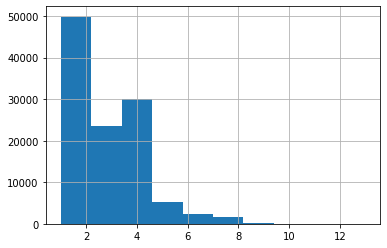

In [9]:
# subject 별 relation 가짓 수
(
    train_df
    .drop_duplicates(['subject','relation'])    
    .groupby('subject')
    ['relation']
    .count()
    .hist()
)
plt.show()

In [10]:
(
    train_df
    .relation
    .value_counts()
    .head()
)

isAffiliatedTo    373783
playsFor          321024
isLocatedIn        88672
hasGender          66163
wasBornIn          44978
Name: relation, dtype: int64

## `TransE`
---
![](https://imgur.com/qWFcZ15.png)

* **reference** : [Translating Embeddings for Modeling Multi-relational Data](https://papers.nips.cc/paper/5071-translating-embeddings-for-modeling-multi-relational-data)

### triplet과 knowledge graph 

지식그래프(Knowledge Graph)은 하나의 지식 체계를 아래와 같은 방식으로 표현합니다.

![](https://imgur.com/5armrMx.png)

시작점(Subject)와 도착점(object), 그리고 그 관계선(relation)으로 이루어진 **Triplet**의 묶음으로 Knowledge Graph가 형성됩니다.

아래의 각 행이 **Triplet**: $(h, r, t)$가 되고 전체 데이터프레임이 **Knowledge Graph**($\mathcal{G}$)가 됩니다.

In [11]:
train_df.head()

,subject,relation,object
0,Chatou,isLocatedIn,France
1,Boo_Young-tae,playsFor,Yangju_Citizen_FC
2,Toni_Kuivasto,isAffiliatedTo,Helsingin_Jalkapalloklubi
3,Josh_Smith_(soccer),playsFor,Trinity_University_(Texas)
4,Albrecht_Dürer,diedIn,Nuremberg


### 목적 : Graph Representation Learning

<img src="https://imgur.com/2edARFX.png" width="500">

#### 우리의 목표를 수행하기 위해서 우리는 크게 2가지를 구현해야 합니다. 

* **encoding function** : 각 node를 저차원의 벡터로 어떻게 변환하는가?
    - $ENC(v)  = Z_v$

* **similarity function** : node 간 유사도를 어떻게 정의하는가? 
    - $similarity(u, v)$


### Encoder의 방식 : Swallow Encoding

가장 단순한 방식은 encoder을 각 노드에 대한 Embedding-Lookup Table을 구성하는 것입니다.각 노드는 고유한 embedding Vector에 1:1로 매칭되어 있습니다. Encoder를 학습하는 것은 
노드 별 Embedding Vector을 학습시키는 것과 같습니다.

![](https://imgur.com/IcpbiP4.png)

#### Keras Code로 작성하기

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomUniform

In [13]:
num_nodes = len(set(train_df.subject) | set(train_df.object))
num_edges = len(set(train_df.relation))
embed_size = 20

# 초기화 방식은 논문에 나와있는 방식으로 구성
init_range = 6/np.sqrt(embed_size)
init_op = RandomUniform(-init_range, init_range)

node_embed_layer = Embedding(input_dim=num_nodes,
                             output_dim=embed_size,
                             embeddings_initializer=init_op,
                             name='node_embed_layer')
edge_embed_layer = Embedding(input_dim=num_edges, 
                             output_dim=embed_size,
                             embeddings_initializer=init_op,
                             name='edge_embed_layer')

### 목적함수 

`transE` 모델의 핵심 아이디어는 바로 

> subject와 relation의 Vector 합은 바로 Object이다


<img src="https://miro.medium.com/max/1040/0*kB60MaVUmaeD1wyt.jpg" width="200">


이를 달성하기 위해, $h + r \approx t$가 되도록 학습합니다. 하지만 단순히 $ Loss = |h + r - t| $ 식으로 손실함수를 설계하면, $h,r,t$ 모두 0으로 학습할 수 있기 때문에, 적절한 제약조건을 추가해야 합니다. 이를 위해 transE에서는 Corrupted Triplets을 도입합니다. Corrupted Triplets은 Knowledge Graph에는 등장하지 않는 Negative Case로, 해당 케이스는 margin보다 더 큰 값이 되도록 하고, Knowledge Graph에 등장한 Positive Case들은 0으로 수렴하도록 손실함수를 구성합니다.

$
L(h,r,t) = max(0, d_{triplet} - d_{corrupted} + margin)\\
d = || h + r - t ||
$

우선 데이터 입력 부분과 corrupted triplets을 생성해보도록 하겠습니다.

#### 데이터 파이프라인 구성하기

In [14]:
# value들은 id로 mapping
nodes = set(train_df.subject.unique()) | set(train_df.object.unique())

id2node = { i:node for i, node in enumerate(nodes)}
node2id = { node:i for i, node in enumerate(nodes)}

edges = set(train_df.relation.unique())

id2edge = { i:edge for i, edge in enumerate(edges)}
edge2id = { edge:i for i, edge in enumerate(edges)}

In [15]:
def shuffle_array(arr):
    """
    주어진 numpy Array의 순서를 임의대로 섞는 함수
    """
    arr = arr.copy()
    np.random.shuffle(arr)
    return arr    

def corrupt_triplet(triplet):
    """
    주어진 triplet을 corrupt하여 학습 데이터로 변환하는 작업
    """
    t = triplet
    if tf.random.uniform((),0.,1.) < 0.5:
        # corrupt object
        return {
            "pos_subject":t['subject'], "neg_subject":t['subject'],            
            "pos_object":t['object'], "neg_object":t['shuffled_object'],
            "relation":t['relation']}
    else:
        # corrupt subject
        return {
            "pos_subject":t['subject'], "neg_subject":t['shuffled_subject'],            
            "pos_object":t['object'], "neg_object":t['object'],
            "relation":t['relation']}

def generate_triplet_dataset(df, node2id, edge2id):    
    """
    
    """
    shuffled_df = df.sample(frac=1.)
    subjects = shuffled_df.subject.map(node2id).values
    relations = shuffled_df.relation.map(edge2id).values
    objects = shuffled_df.object.map(node2id).values

    triplets = tf.data.Dataset.from_tensor_slices({
        "subject":subjects,
        "object":objects,
        "relation":relations,
        "shuffled_subject": shuffle_array(subjects),
        "shuffled_object": shuffle_array(objects)
    }).map(corrupt_triplet)
    return triplets

#### 입력층과 임베딩층 구성하기

세부 구현사항

* with the additional constraints that th L2-norm of the embeddings of the entities is 1 ( no regularization or norm constraints are given to the label embeddings). (논문 3page 발췌)

In [16]:
pos_sub_inputs = Input(shape=(), name='pos_subject')
neg_sub_inputs = Input(shape=(), name='neg_subject')
pos_obj_inputs = Input(shape=(), name='pos_object')
neg_obj_inputs = Input(shape=(), name='neg_object')
rel_inputs = Input(shape=(), name='relation')

pos_sub_embed = K.l2_normalize(node_embed_layer(pos_sub_inputs),axis=1)
neg_sub_embed = K.l2_normalize(node_embed_layer(neg_sub_inputs),axis=1)
pos_obj_embed = K.l2_normalize(node_embed_layer(pos_obj_inputs),axis=1)
neg_obj_embed = K.l2_normalize(node_embed_layer(neg_obj_inputs),axis=1)
rel_embed = edge_embed_layer(rel_inputs)

#### 손실함수 구성하기

세부 구현사항
* Following an energy-based framework, the energy of a triplet is equal to $d(h+l,t)$ for some dissimilarity measure $d$, which we take to be eight the $L_1$ or the $L_2$-norm.

In [19]:
def distance(src_embed, dst_embed, norm='l1'):
    """
    src_embed와 dst_embed의 거리
    
    src_embed : subject + relation
    dst_embed : object
    """
    if norm == 'l1':
        return K.sum(K.abs(src_embed -dst_embed),1)
    elif norm == 'l2':
        return K.sum(K.square(src_embed - dst_embed),1)
    else:
        raise NotImplemented

pos_dist = distance(pos_sub_embed+rel_embed, pos_obj_embed)
neg_dist = distance(neg_sub_embed+rel_embed, neg_obj_embed)

margin = 1
loss = K.maximum(margin + pos_dist - neg_dist, 0.)

#### 모델 구성하기

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad, SGD

inputs = (pos_sub_inputs, neg_sub_inputs, 
          pos_obj_inputs, neg_obj_inputs, rel_inputs)

model = Model(inputs, loss)
model.add_loss(loss)
model.compile(optimizer=Adagrad(1e-3))

#### 모델 학습하기

In [ ]:
num_epochs = 10
batch_size = 10000
for i in range(1,num_epochs+1):
    print(f"Epoch : {i}th")
    triplets = generate_triplet_dataset(train_df, node2id, edge2id)
    model.fit(x=triplets.batch(batch_size))

Epoch : 1th
108/108 [==============================] - 59s 545ms/step - loss: 0.5357
Epoch : 2th
108/108 [==============================] - 59s 543ms/step - loss: 0.5356
Epoch : 3th
108/108 [==============================] - 61s 561ms/step - loss: 0.5343
Epoch : 4th
108/108 [==============================] - 59s 543ms/step - loss: 0.5350
Epoch : 5th
108/108 [==============================] - 59s 549ms/step - loss: 0.5340
Epoch : 6th
108/108 [==============================] - 57s 531ms/step - loss: 0.5340
Epoch : 7th
108/108 [==============================] - 58s 533ms/step - loss: 0.5349
Epoch : 8th
108/108 [==============================] - 59s 544ms/step - loss: 0.5348
Epoch : 9th
 25/108 [=====>........................] - ETA: 41s - loss: 0.5335

In [67]:
node_embed = model.get_layer('node_embed_layer').get_weights()[0]
edge_embed = model.get_layer('edge_embed_layer').get_weights()[0]

l2_norm = np.linalg.norm(node_embed,ord=1,axis=1)[:,None]
node_normalized = node_embed / l2_norm
node_df = pd.DataFrame(node_normalized)
node_df.index = node_df.index.map(id2node)

In [69]:
node_df.dot(node_df.loc['Habib_Beye']).sort_values(ascending=False)

Habib_Beye                                    0.064453
Elvis_Kokalović                               0.056181
Tadayo_Fukuo                                  0.054580
Gordon_Riddick                                0.054363
Stefano_Fanucci                               0.052609
                                                ...   
Suzy_McKee_Charnas                           -0.051982
Anni_Sinnemäki                               -0.052616
James_MacArthur                              -0.053483
Ireland_national_football_team_(1882–1950)   -0.056391
David_Dhawan                                 -0.057258
Length: 123143, dtype: float32

In [70]:
node_df.dot(node_df.loc['The_Eastern_Iowa_Airport']).sort_values(ascending=False)

The_Eastern_Iowa_Airport           0.062915
Mykonos_Island_National_Airport    0.056881
Umeå_FC                            0.055911
Santander_Airport                  0.054075
Bolivia_national_football_team     0.053887
                                     ...   
Keene,_New_York                   -0.053890
Thanasis_Sentementes              -0.055681
David_Sánchez_Rodríguez           -0.055816
Near_East                         -0.056733
Wayne_Hennessey                   -0.057080
Length: 123143, dtype: float32